In [1]:
import math
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import poppy as pp
import organized_functions as pr

%load_ext autoreload # reload 'autoreload'
%autoreload 2 # autonomously reload all import modules
%matplotlib inline # directly show images in the notebook


C:\Users\yiyan\.conda\envs\phase_retrieval_LFAST\Lib\site-packages\cupyx\jit\_interface.py:173: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


ModuleNotFoundError: No module named "autoreload # reload 'autoreload'"

# Generate the pupil image

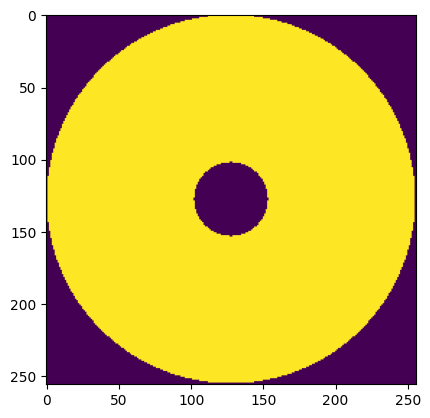

In [2]:
wavelength = 580e-9 # wavelength in meters
od_pupil = 0.3808 # outer pupil diameter in meters
id_pupil = 0.0762 # inner pupil diameter in meters
npix_pupil = 256 # sampling rate on a single side of the pupil

x = cp.linspace(-od_pupil / 2, od_pupil / 2, npix_pupil) # give a 1 x 512 vector in range [-d_pupil/2, d_pupil/2]
x, y = cp.meshgrid(x, x) # use 2 vectors to generate 2 mesh grids
r = cp.sqrt(x ** 2 + y ** 2) # radius

pupil = cp.ones_like(r) # create a matrix whose size and data format are similar to 'r' and value is 1
pupil[r >= od_pupil / 2] = 0 # update the pupil according to the positions obtained through 'r'
pupil[r <= id_pupil / 2] = 0

plt.imshow(pupil.get())
plt.show()


# Get OPD

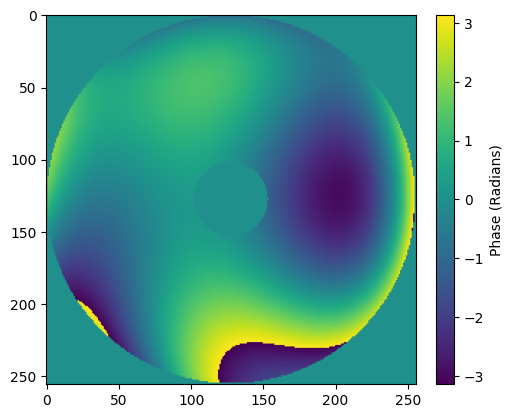

In [19]:
coeffs = cp.array([0.01, -0.02, 0.05, 0.05, 0.1, -0.1, 0.02, 0.1, -0.07, -0.03, 0.02, 0.1, 0.01, 0.05]) # coefficients of Zernike polynomials in wave number
coeff_num = len(coeffs)
zernikes = pp.zernike.arbitrary_basis(pupil, nterms=coeff_num, outside=0)

total_opd = np.sum(zernikes * coeffs[:, np.newaxis, np.newaxis], axis=0)
opd = np.exp(1j * total_opd * 2 * np.pi)

plt.imshow(np.angle(opd).get())
plt.colorbar(fraction=0.046, pad=0.04, label='Phase (Radians)')
plt.show()

# Get defocus probes

(100, 5, 256, 256)
100


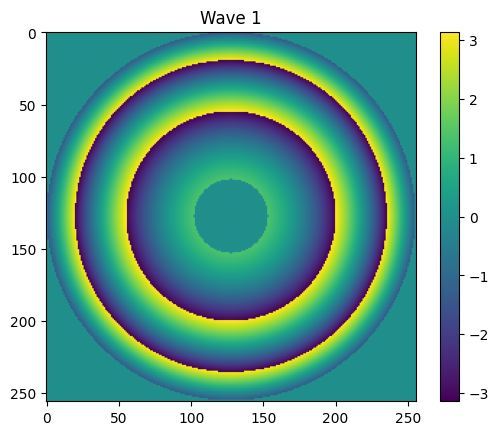

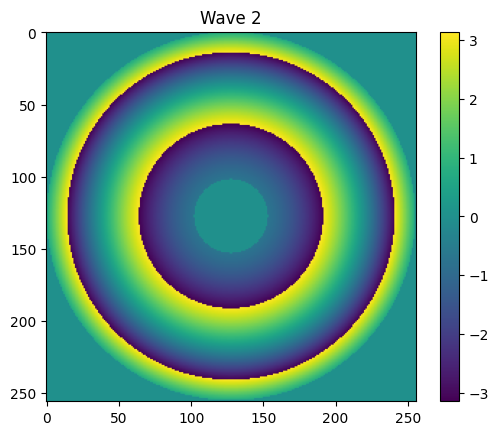

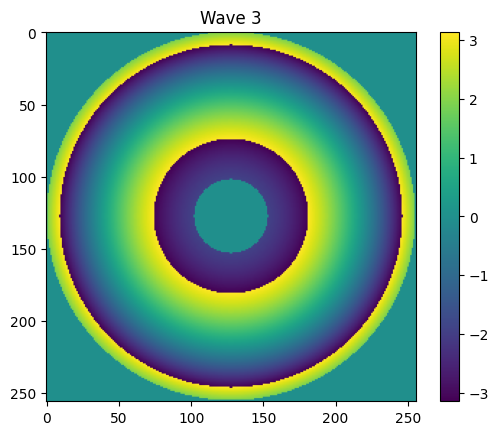

In [24]:
focal_length = 2.537 # focal length in meters
position = cp.array([-100, -50, 0, 50, 100]) # defocus distances in microns
position = position * 1e-6 # in meters

wavelengths = np.linspace(400e-9, 700e-9, 100)  # 100 wavelengths in meters

broadband_probes = [] # initialize a list to store probes for different wavelengths
for wl in wavelengths:
    defocus_values = position/ (8 * wl * (focal_length / od_pupil) ** 2)  # defocus distance is calculated from L = 8Qλ(f/D)^2, so the defocus wave number can be inversely calculated through this
    probes = pr.get_defocus_probes(pupil, defocus_values)
    broadband_probes.append(probes)
broadband_probes = np.stack(broadband_probes, axis=0)
print(broadband_probes.shape) # get the shape of the broad band probes

wave_number = broadband_probes.shape[0] # wavelength layer
print(wave_number)

plt.imshow(np.angle(broadband_probes[0, 0]).get())
plt.colorbar()
plt.title('Wave 1')
plt.show()

plt.imshow(np.angle(broadband_probes[49, 0]).get())
plt.colorbar()
plt.title('Wave 2')
plt.show()

plt.imshow(np.angle(broadband_probes[99, 0]).get())
plt.colorbar()
plt.title('Wave 3')
plt.show()


# Simulate the PSF

(100, 5, 256, 256)
(5, 256, 256)


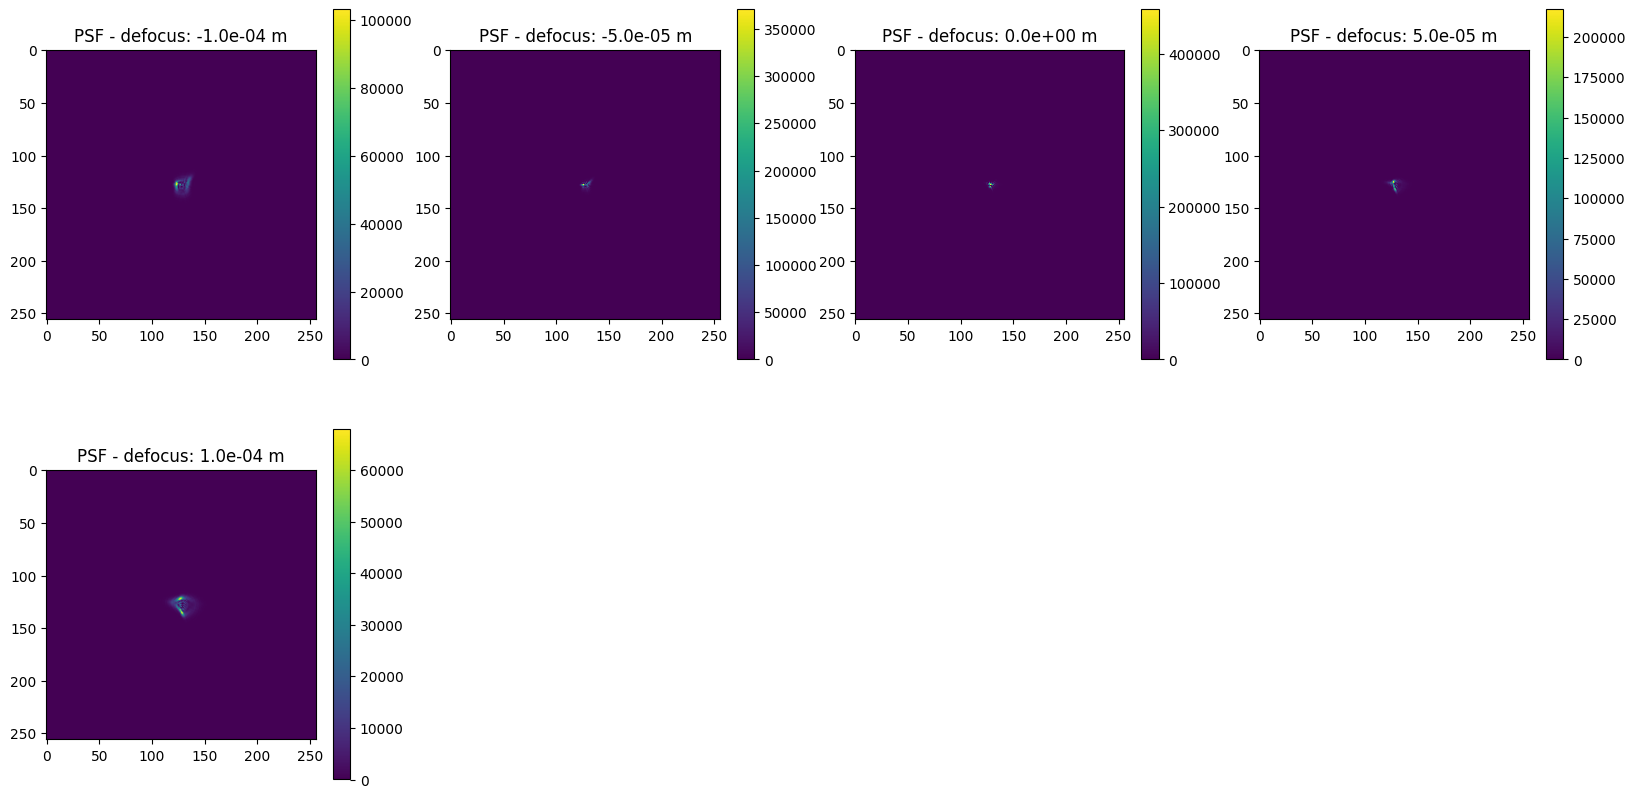

In [26]:
std = 1
spectrum = cp.random.normal(0, scale=std, size=wave_number) # intensities of different wavelengths
spectrum = (spectrum - spectrum.min()) / (spectrum.max() - spectrum.min())

# Get PSF for each wavelength
broadband_intensities = []
for wl in wavelengths:
    broadband_probes_wave = broadband_probes[wl, :, :, :]
    focal_intensities, _, _ = pr.forward_model(pupil, broadband_probes_wave, opd)
    broadband_intensities.append(focal_intensities)
broadband_intensities = np.stack(broadband_intensities, axis=0)
print(broadband_intensities.shape) # get the shape of the broadband intensities

# PSF of the broadband input
defocus_intensities = np.sum(broadband_intensities * spectrum[:, None, None, None], axis=0)
print(defocus_intensities.shape)

defocus_num = defocus_intensities.shape[0]
image_size = 5
col_num = 4 # column number of images for display
row_num = math.ceil(defocus_num / col_num) # row number of images for display
plt.figure(figsize=(image_size * col_num, image_size * row_num))
for i in range(defocus_num):
    position_info = position[i] # defocus distance
    plt.subplot(row_num, col_num, i+1)
    plt.imshow(defocus_intensities[i].get())
    plt.title(f'PSF - defocus: {position_info.get():.1e} m')
    plt.colorbar()
plt.show()


# Do phase retrieval


Imeas type: <class 'cupy.ndarray'>
fitmask type: <class 'cupy.ndarray'>
Eprobes type: <class 'cupy.ndarray'>
modes type: <class 'cupy.ndarray'>
<class 'cupy.ndarray'>


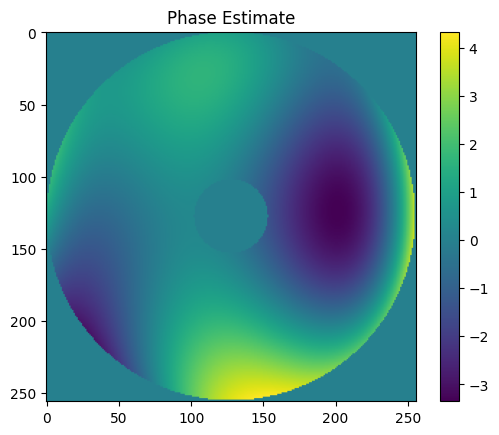

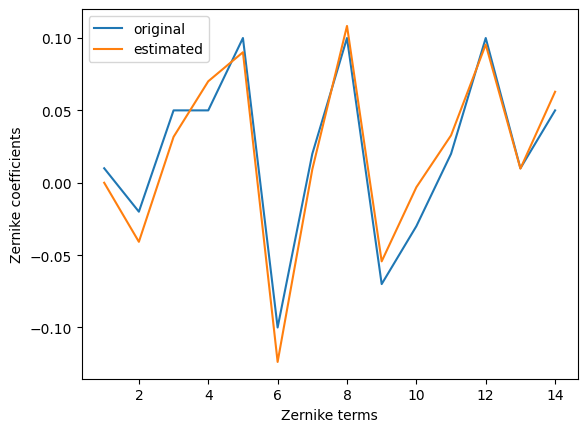

In [27]:
zernikes = pp.zernike.arbitrary_basis(pupil, nterms=coeff_num, outside=0) # give the bases of 45 zernike polynomials
single_probe = broadband_probes[49]
print("Imeas type:", type(defocus_intensities))
print("fitmask type:", type(pupil))
print("Eprobes type:", type(probes))
print("modes type:", type(zernikes))

phase_retrieval_dict = pr.run_phase_retrieval(Imeas=defocus_intensities, fitmask=pupil, Eprobes=single_probe, modes=zernikes, tol=1e-8, reg=0, wreg=1e3, fit_amp=False)
print(type(phase_retrieval_dict['fit_params']))
estimated_coeffs = phase_retrieval_dict['fit_params'] # returns in units of radians

np_phase = phase_retrieval_dict['phase_est'].get()
# np.save('phase_estimate.npy', np_phase)
plt.imshow(phase_retrieval_dict['phase_est'].get())
plt.colorbar()
plt.title('Phase Estimate')
# plt.savefig('Phase Estimate.png')
plt.show()

hori_axis = np.linspace(1, coeff_num, coeff_num, dtype=int)
original_coeffs = cp.asnumpy(coeffs)
estimate_coeffs = cp.asnumpy(estimated_coeffs[:coeff_num]) / (2 * cp.pi)

plt.plot(hori_axis, original_coeffs, label='original')
plt.plot(hori_axis, estimate_coeffs, label='estimated')
plt.legend()
plt.xlabel('Zernike terms')
plt.ylabel('Zernike coefficients')
plt.show()
